# NB-HI4: Long-term annual total fluxes changes for early, mid and late 21st century periods from historical period

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change

Last executed: 2021-03-06 11:43:44.161352 by mizukami on casper03


In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [6]:
figSave = True

In [7]:
region          = 'HI'
gcms            = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
hydro_flux_vars = ['PRCP', 'EVAP', 'total_runoff']
period_hist     = slice('1970-01-01', '1999-12-31')
period_futr     = {'early' : slice('2010-01-01', '2039-12-31'),
                   'middle': slice('2040-01-01', '2069-12-31'),
                   'late'  : slice('2070-01-01', '2099-12-31')}

## Load the data

In [8]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=hydro_flux_vars, region=region, parallel=False)
rcp45_data = load_monthly_cmip5_hydro_datasets(scen='rcp45', models=gcms, variables=hydro_flux_vars, region=region, parallel=False)
rcp85_data = load_monthly_cmip5_hydro_datasets(scen='rcp85', models=gcms, variables=hydro_flux_vars, region=region, parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:50<00:00,  5.06s/it]

load_obs_dataset


load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [01:46<00:00, 10.68s/it]

load_monthly_cmip5_hydro_datasets
load_cmip5_dataset



100%|██████████| 10/10 [01:38<00:00,  9.83s/it]


## Compute 30-yr annual mean for 4 periods - historical, early, mid and late

In [10]:
histo_hydro_means = resample_data(histo_data['gcm'].sel(time=period_hist), region=region, freq='AS').persist().mean('time')

rcp45_hydro_means = {}
rcp85_hydro_means = {}
for key, futr_period in period_futr.items():
    rcp45_hydro_means[key] = resample_data(rcp45_data.sel(time=futr_period), region=region, freq='AS').persist().mean('time')
    rcp85_hydro_means[key] = resample_data(rcp85_data.sel(time=futr_period), region=region, freq='AS').persist().mean('time')

## Compute difference in 30-yr annual mean between historical and future

In [11]:
rcp45_hydro_30yr_diff = {}
rcp85_hydro_30yr_diff = {}
diff_rcp_hydro_30yr_change ={}
for key, futr_period in period_futr.items():
    rcp45_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp45_hydro_means[key], pct=True).persist()
    rcp85_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp85_hydro_means[key], pct=True).persist()
    
    diff_rcp_hydro_30yr_change[key] =rcp85_hydro_30yr_diff[key] - rcp45_hydro_30yr_diff[key]

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x

## Plotting

In [12]:
# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

------------
 - The same as above except for two future periods in 21st century (early, mid, and late) 

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

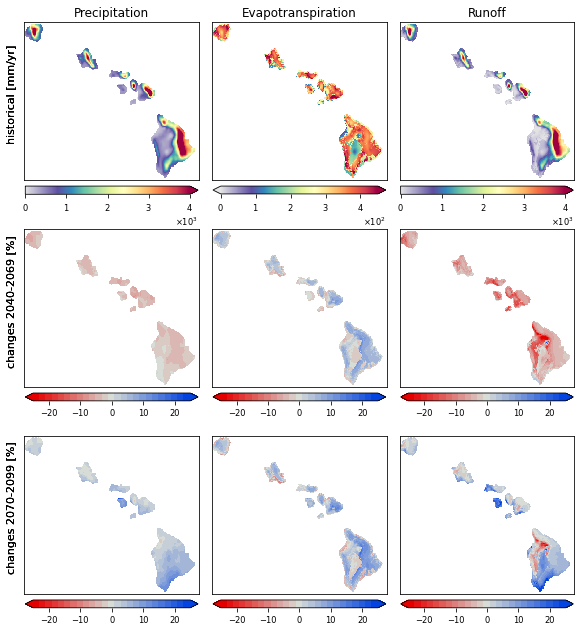

In [13]:
cm = {'history'   : cmap,
      'change'    : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'change_RO' : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),}

norm = {'PRCP': MidpointNormalize(vmin=-25, vmax=25, midpoint=0),
        'EVAP': MidpointNormalize(vmin=-25, vmax=25, midpoint=0),
        'ROFF': MidpointNormalize(vmin=-25, vmax=25, midpoint=0)}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean':   {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change-PRCP':         {'norm':norm['PRCP'], 'cmap':cm['change'],    'extend':'both', **style_kwargs['change']},
          'change-EVAP':         {'norm':norm['EVAP'], 'cmap':cm['change'],    'extend':'both', **style_kwargs['change']},
          'change-total_runoff': {'norm':norm['ROFF'], 'cmap':cm['change_RO'], 'extend':'both', **style_kwargs['change']},
          'PRCP':                {'vmin':0, 'vmax':4000, 'cmap':cm['history'], 'extend':'max',  **style_kwargs['mean']}, #'levels': 31, 
          'EVAP':                {'vmin':0, 'vmax':450,  'cmap':cm['history'], 'extend':'both', **style_kwargs['mean']}, #'levels': 17, 
          'total_runoff':        {'vmin':0, 'vmax':4000, 'cmap':cm['history'], 'extend':'max',  **style_kwargs['mean']}} #'levels': 11, 

var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8.125,8.75))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.075)

for col, var in enumerate(['PRCP','EVAP','total_runoff']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[f'change-{var}'])
    rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col],   **kwargs[f'change-{var}'])
    
    add_ylabel(axes[0, 0], 'historical [mm/yr]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [%]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [%]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
plt.savefig(f'NB-HI4_Fig1_annual_mean_pchange_mid_late_rcp85.png', dpi=300)

------------
 - Difference between two RCPs in change in 30yr mean annual total for late 21st century

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


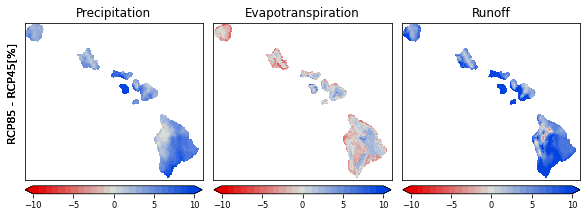

In [14]:
cm = {'change' : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.995, pad=0.03)}
kwargs       = {'change-rcp': {'vmin':-10, 'vmax':10,  'cmap':cm['change'], 'extend':'both', **style_kwargs},
               }

var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(8.125,3))
plt.subplots_adjust(left=0.040, bottom=0.0125, right=0.990, top=0.900, hspace=0.060, wspace=0.060)

for col, var in enumerate(['PRCP','EVAP','total_runoff']):
    diff_rcp_hydro_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[col], **kwargs['change-rcp'])
    
    add_ylabel(axes[0], 'RCP85 - RCP45[%]', fontsize=11)
    axes[col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
plt.savefig(f'NB-HI4_Fig2_annual_mean_pchange_late_diff_rcp.png', dpi=300)

--------
- Climate changes for individual GCMs for late 21st century are plotted below

--------------------
### Precipitation

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


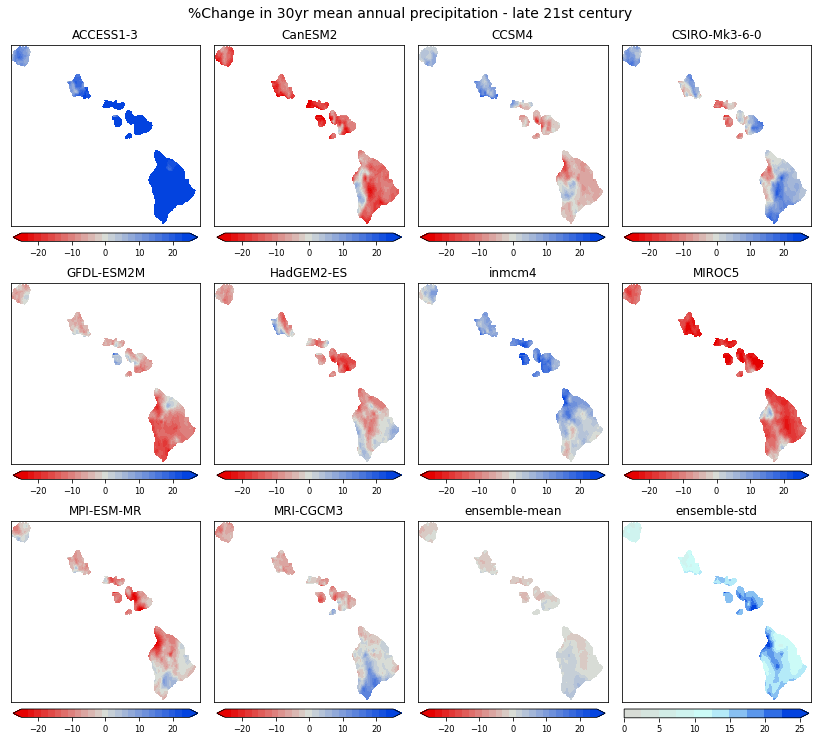

In [15]:
var="PRCP"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

norm2 = MidpointNormalize(vmin=-25, vmax=25, midpoint=0)

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'norm':norm2, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,    'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
#plt.tight_layout()
fig.suptitle('%Change in 30yr mean annual precipitation - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig3_annual_mean_pchange_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


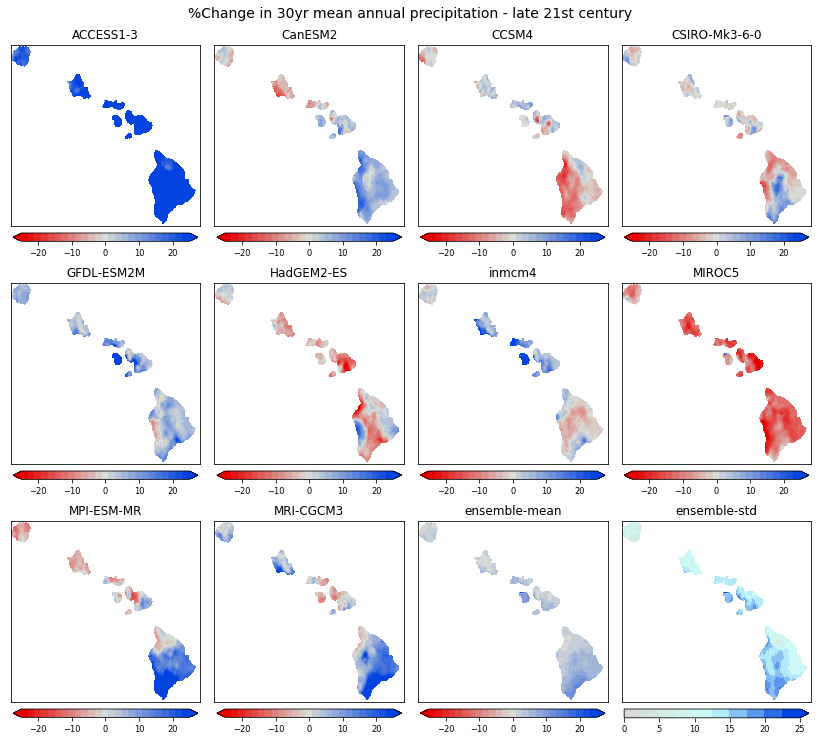

In [16]:
var="PRCP"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

norm = MidpointNormalize(vmin=-25, vmax=25, midpoint=0)

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'norm':norm, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,    'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('%Change in 30yr mean annual precipitation - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig4_annual_mean_pchange_late_{var}_rcp85.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


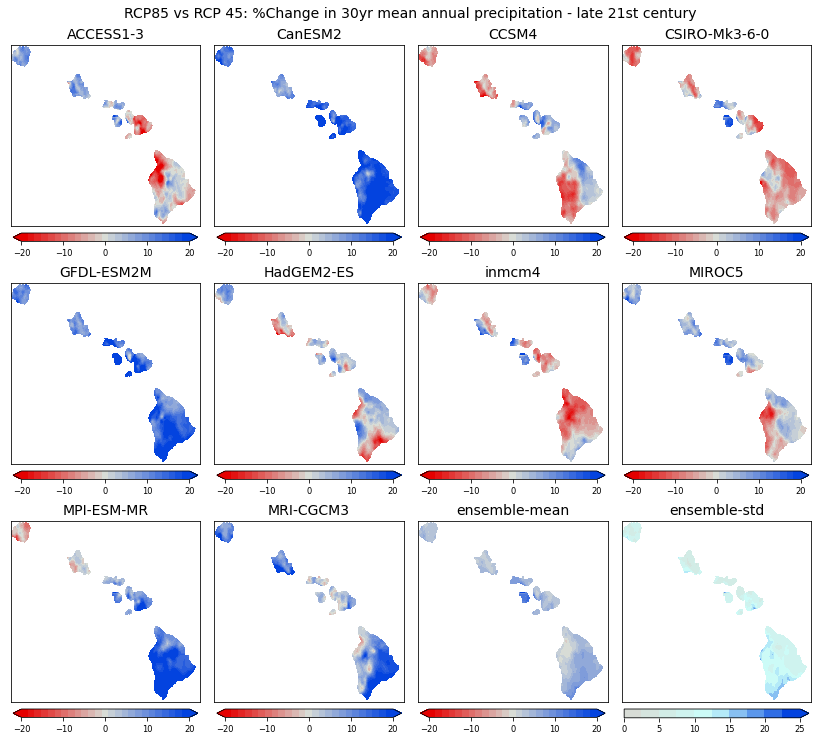

In [17]:
var="PRCP"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'vmin':-20, 'vmax':20, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,   'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        diff_rcp_hydro_30yr_change['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        diff_rcp_hydro_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        diff_rcp_hydro_30yr_change['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('RCP85 vs RCP 45: %Change in 30yr mean annual precipitation - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig5_annual_mean_pchange_late_{var}_rcp_diff.png', dpi=300)

--------------------
### total runoff

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


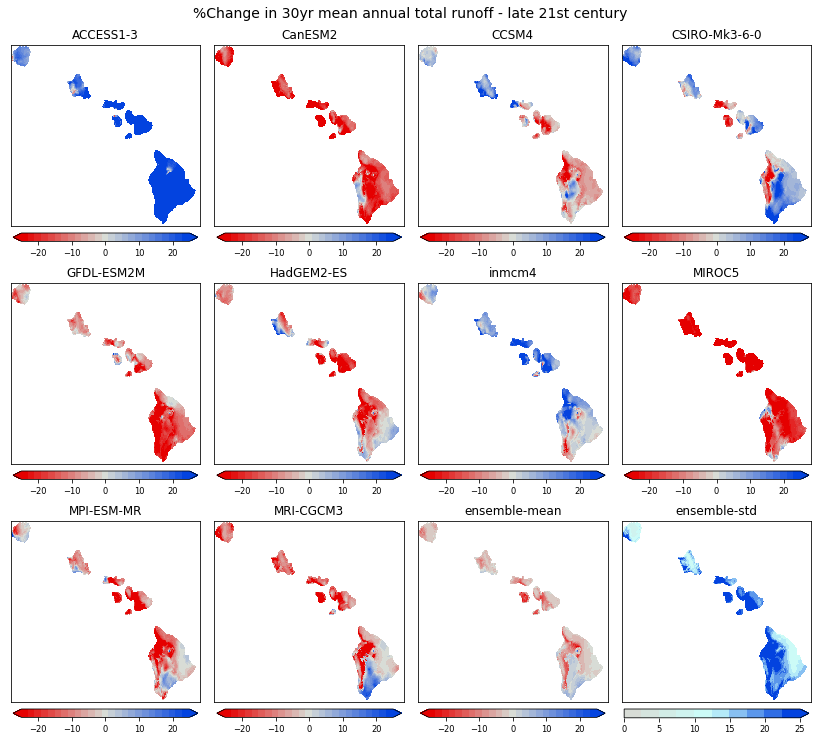

In [18]:
var="total_runoff"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

norm2 = MidpointNormalize(vmin=-25, vmax=25, midpoint=0)

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'norm':norm2, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,    'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('%Change in 30yr mean annual total runoff - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig6_annual_mean_pchange_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


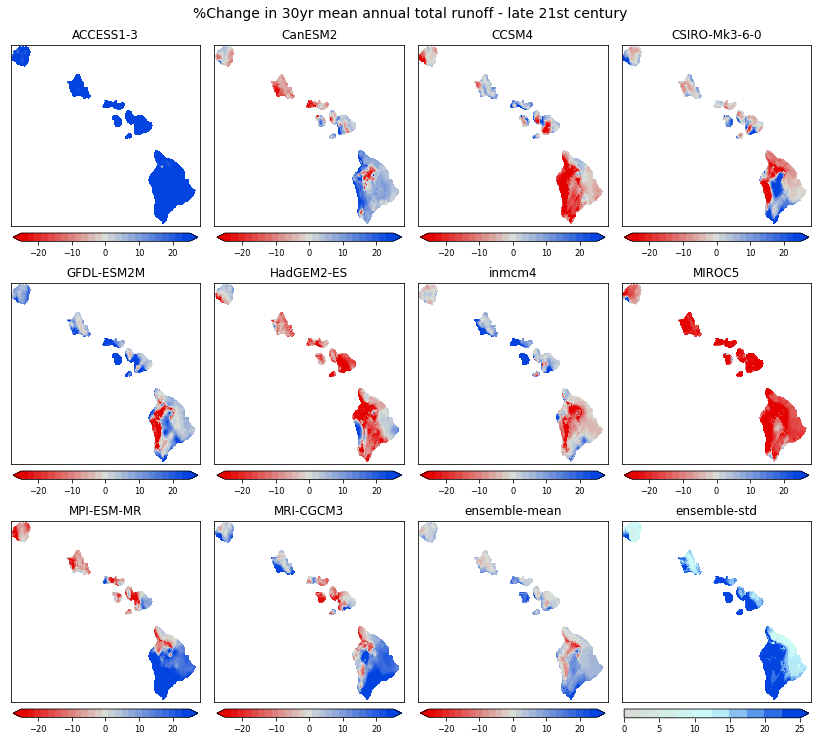

In [19]:
var="total_runoff"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

norm = MidpointNormalize(vmin=-25, vmax=25, midpoint=0)

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'norm':norm, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,    'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('%Change in 30yr mean annual total runoff - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig7_annual_mean_pchange_late_{var}_rcp85.png', dpi=300)

#### rcp85 - rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


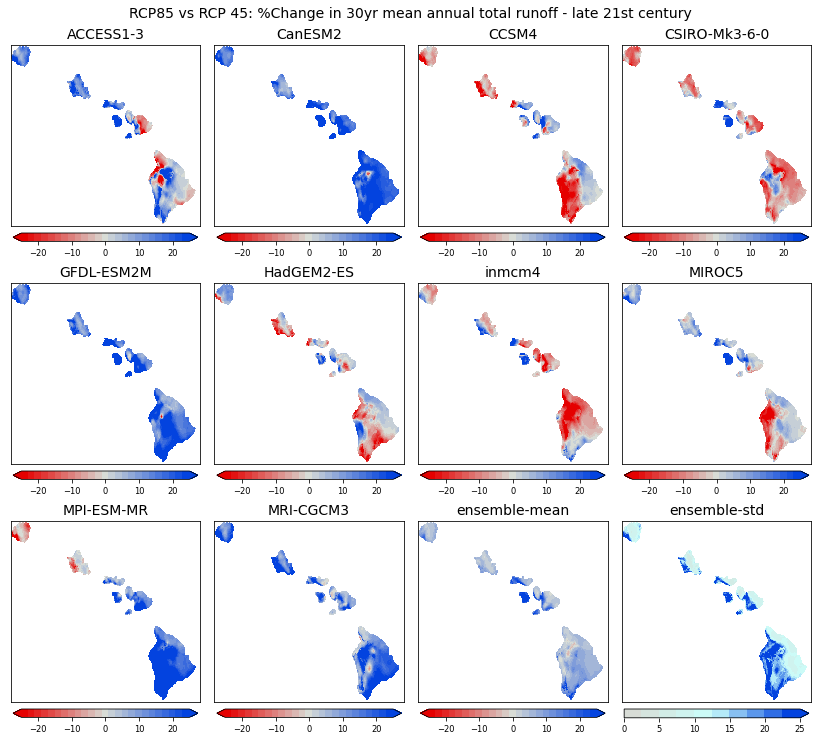

In [20]:
var="total_runoff"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'vmin':-25, 'vmax':25, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,   'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        diff_rcp_hydro_30yr_change['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        diff_rcp_hydro_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        diff_rcp_hydro_30yr_change['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('RCP85 vs RCP 45: %Change in 30yr mean annual total runoff - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig8_annual_mean_pchange_late_{var}_rcp_diff.png', dpi=300)

-------------------------
### Evapotranspiration

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


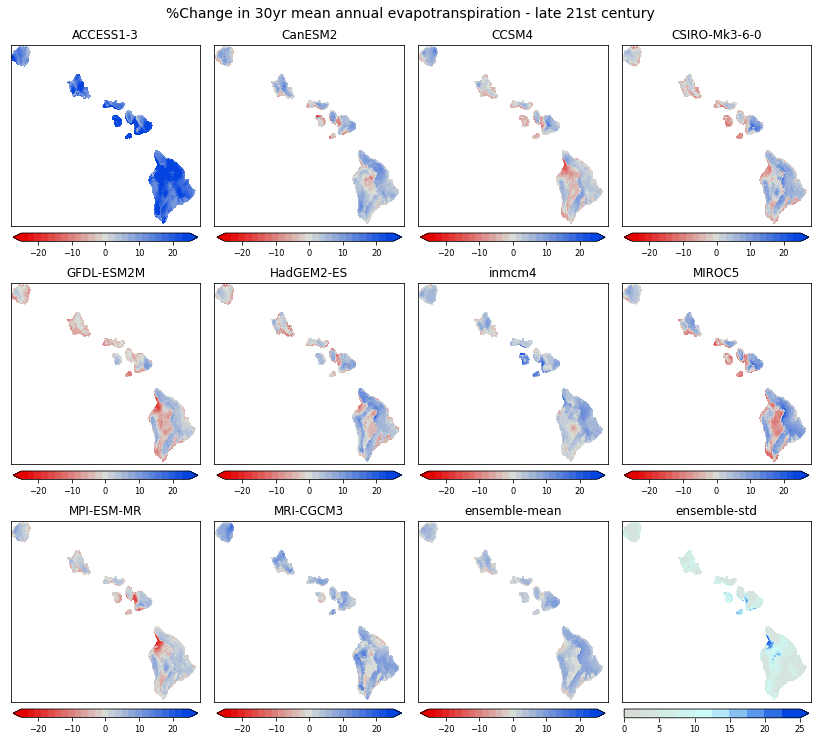

In [21]:
var="EVAP"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'vmin':-25, 'vmax':25, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,   'vmax':25, 'cmap':cm['std'], 'extend':'max', **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('%Change in 30yr mean annual evapotranspiration - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig9_annual_mean_pchange_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


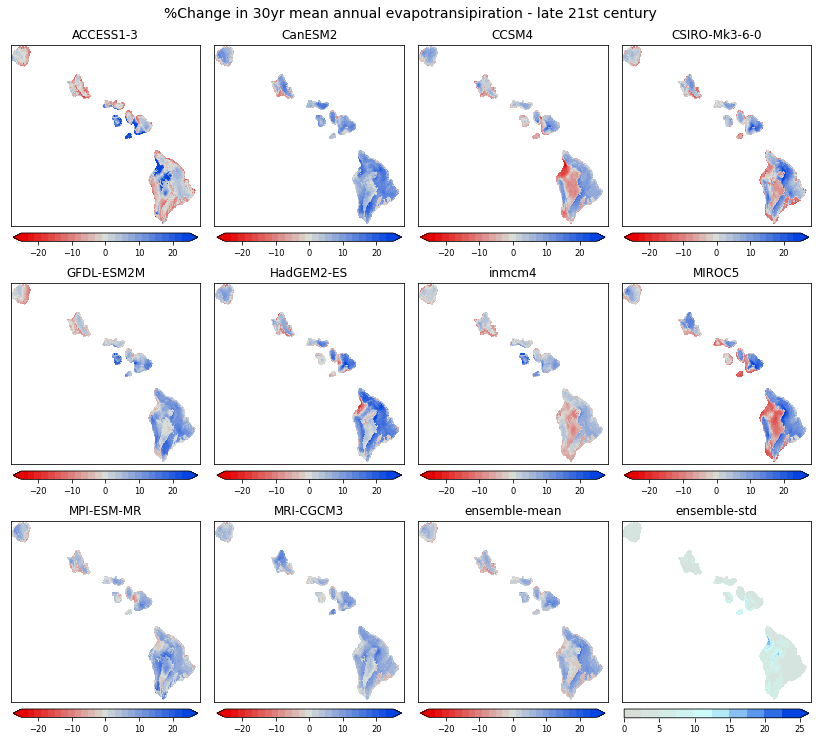

In [22]:
var="EVAP"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'vmin':-25, 'vmax':25, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,   'vmax':25, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_hydro_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_hydro_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('%Change in 30yr mean annual evapotransipiration - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig10_annual_mean_pchange_late_{var}_rcp85.png', dpi=300)

#### RCP85 - RCP45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


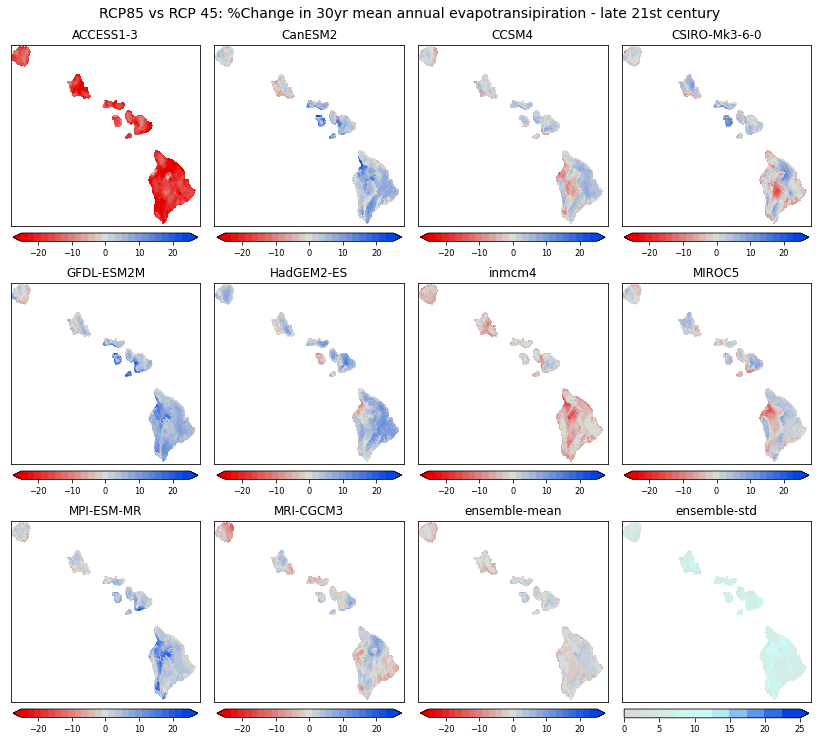

In [23]:
var="EVAP"

cm = {'mean': custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue'),
      'std' : custom_div_cmap(numcolors=10, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.975, pad=0.03)}
kwargs = {'mean': {'vmin':-25, 'vmax':25, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'vmin':0,   'vmax':25, 'cmap':cm['std'],  'extend':'max', **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        diff_rcp_hydro_30yr_change['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        diff_rcp_hydro_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        diff_rcp_hydro_30yr_change['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('RCP85 vs RCP 45: %Change in 30yr mean annual evapotransipiration - late 21st century', fontsize=14, y=0.985)

if figSave:
    plt.savefig(f'NB-HI4_Fig11_annual_mean_pchange_late_{var}_rcp_diff.png', dpi=300)

In [ ]:
6.5*1.8

In [ ]:
6*1.8